# An application of Federated Learning in a Smart Home Environment

## Smart + Dataset 

### Read the data

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path="/Users/daniel.bustillo/Documents/thesis"

os.chdir(path)

In [4]:
home_a = pd.read_csv("Dataset/home_a.csv",infer_datetime_format=True, parse_dates=True, index_col=0)
home_b = pd.read_csv("Dataset/home_b.csv",infer_datetime_format=True, parse_dates=True, index_col=0)
home_c = pd.read_csv("Dataset/home_c.csv",infer_datetime_format=True, parse_dates=True, index_col=0)
home_d = pd.read_csv("Dataset/home_d.csv",infer_datetime_format=True, parse_dates=True, index_col=0)
home_f = pd.read_csv("Dataset/home_f.csv",infer_datetime_format=True, parse_dates=True, index_col=0)
home_g = pd.read_csv("Dataset/home_g.csv",infer_datetime_format=True, parse_dates=True, index_col=0)
home_h = pd.read_csv("Dataset/home_h.csv",infer_datetime_format=True, parse_dates=True, index_col=0)

In [5]:
homes= [home_a, home_b, home_c, home_d, home_f, home_g, home_h]

### Outlier removal with KATS

In [97]:

from kats.consts import TimeSeriesData

# Construct TimeSeriesData object

home_f['time'] = home_f.index
df = home_f.rename(columns={"total": "value"}).reset_index()
df= df[['time','value']]
ts = TimeSeriesData(df)

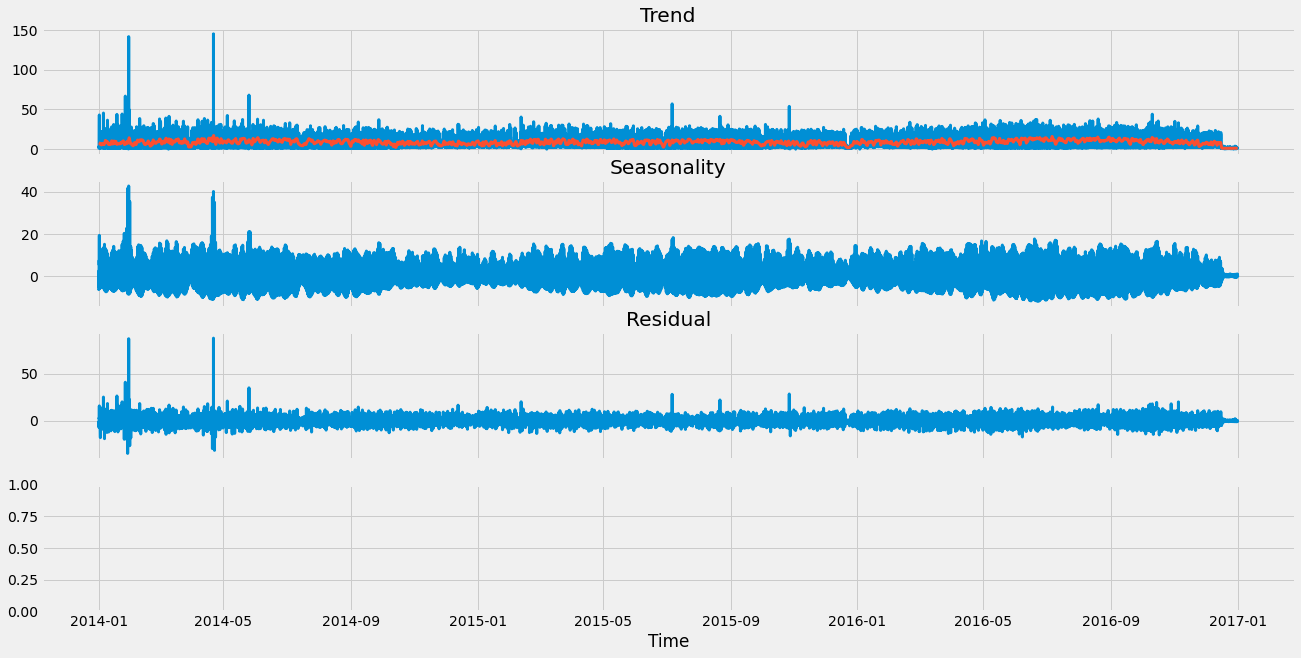

In [98]:
from kats.utils.decomposition import TimeSeriesDecomposition

decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()

In [99]:

from kats.detectors.seasonality import FFTDetector

fft_detector = FFTDetector(ts)
fft_detector.detector()

{'seasonality_presence': True,
 'seasonalities': [8768.0,
  167.54140127388533,
  27.98297872340426,
  24.065873741994512,
  20.992817238627296,
  12.925798525798525]}

<AxesSubplot:>

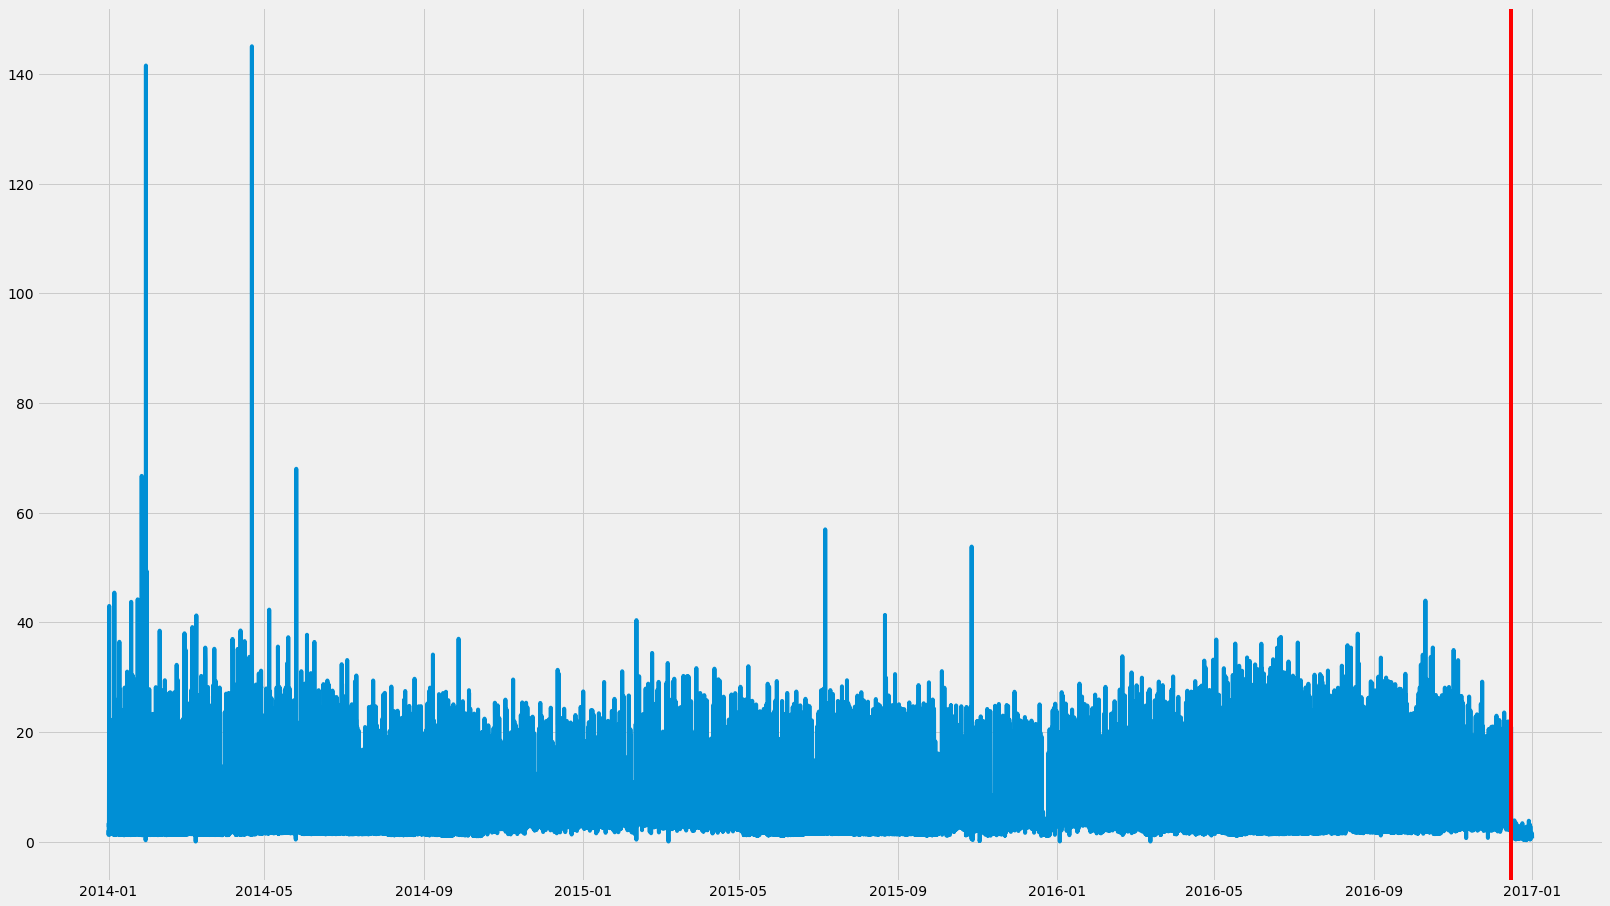

In [102]:

from kats.detectors.cusum_detection import CUSUMDetector

cumsum_detector = CUSUMDetector(ts)
changepoints = cumsum_detector.detector()
#print(changepoints[0][0])

# Plot
cumsum_detector.plot(changepoints)

In [ ]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

bocpd_detector = BOCPDetector(ts)

changepoints = bocpd_detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL
)

    
# Plot
#bocpd_detector.plot(changepoints)

# Plot the data
plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

### Normalization

In [5]:
#normalizing: the ugly way
norm_a = (home_a-home_a.min())/(home_a.max()-home_a.min())

In [6]:
def normalize(df):
    df= (df - df.min())/df.max() - df.min()
    



In [13]:
normalize(home_a)

In [79]:
# values= df_num['total'].values
# values= values.reshape((len(values),1))

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = scaler.fit(values)
# print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# # normalize the dataset and print the first 5 rows
# normalized = scaler.transform(values)
# for i in range(5):
# 	print(normalized[i])
# # inverse transform and print the first 5 rows
# inversed = scaler.inverse_transform(normalized)
# for i in range(5):
# 	print(inversed[i])

# home_a['total_norm'] = normalized

# from scipy import stats
# bc_fitted_feature, bc_fitted_lambda = stats.boxcox(home_a['total']+1) # Again, we are adding 1 because all features have 0s (not allowed in BC)

# bc_fitted_lambda

#home_a['total_transformed'] = bc_fitted_feature

### Feature Engineering

In [7]:
def rm_outliers(df):
    for i in df.columns:
        df[i] = np.where(df[i]>4,df[i].median(),df[i])
    return df.describe()


In [8]:
[rm_outliers(df) for df in homes]

[       use [kW]  gen [kW]_x  FurnaceHRV [kW]  CellarOutlets [kW]  \
 count   13198.0     13198.0     13198.000000        13198.000000   
 mean        0.0         0.0         0.158707            0.080122   
 std         0.0         0.0         0.194058            0.019182   
 min         0.0         0.0         0.003176            0.047828   
 25%         0.0         0.0         0.026500            0.065247   
 50%         0.0         0.0         0.086668            0.074890   
 75%         0.0         0.0         0.174833            0.089828   
 max         0.0         0.0         0.806236            0.213240   
 
        WashingMachine [kW]  FridgeRange [kW]  DisposalDishwasher [kW]  \
 count         13198.000000      13198.000000             1.319800e+04   
 mean              0.000491          0.001341             1.349618e-04   
 std               0.000670          0.005614             1.240071e-04   
 min               0.000007          0.000029             2.780000e-07   
 25%   

In [9]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    # df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['night']= np.where((df['hour']>=18)|(df['hour']<6),1,0)
    df['lag_hour'] = df['total'].shift(periods=1)
    df['lag_day'] = df['total'].shift(periods=24)
    df['lag_week'] = df['total'].shift(periods=168)
    df['weekday'] = df['date'].dt.weekday

    
    # X = df[['hour','dayofweek','quarter','month','year',
    #        'dayofyear','dayofmonth']]
    # if label:
    #     y = df[label]
    #     return X, y
    # return X

# X, y = create_features(home_a, label='total')

# features_and_target = pd.concat([X, y], axis=1)

In [10]:
[create_features(df) for df in homes]

[None, None, None, None, None, None, None]

### Profiling

In [ ]:
%pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

In [67]:
from pandas_profiling import ProfileReport

In [68]:
prof_a= ProfileReport(home_a, title="Home A", explorative=True)

In [69]:
prof_a.to_widgets()

Generate report structure: 100%|██████████| 1/1 [00:17<00:00, 17.07s/it]


### Simple ARIMA model

In [41]:
# simple ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [116]:
#Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(norm_a['total'].dropna(),autolag="AIC")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -12.825696
p-value: 0.000000


In [118]:
#Fitting the conv
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error


train, test = model_selection.train_test_split(norm_a, train_size=0.9)


In [124]:
exog= train.drop(['total', 'use [kW]','gen [kW]_x','gen [kW]_y'], axis=1)

In [125]:
exog.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11879 entries, 2015-07-01 01:00:00 to 2016-11-06 23:00:00
Freq: H
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FurnaceHRV [kW]              11878 non-null  float64
 1   CellarOutlets [kW]           11878 non-null  float64
 2   WashingMachine [kW]          11878 non-null  float64
 3   FridgeRange [kW]             11878 non-null  float64
 4   DisposalDishwasher [kW]      11878 non-null  float64
 5   KitchenLights [kW]           11878 non-null  float64
 6   BedroomOutlets [kW]          11878 non-null  float64
 7   BedroomLights [kW]           11878 non-null  float64
 8   MasterOutlets [kW]           11878 non-null  float64
 9   MasterLights [kW]            11878 non-null  float64
 10  DuctHeaterHRV [kW]           11878 non-null  float64
 11  ElectricRange [kW]           11878 non-null  float64
 12  Dryer [kW]                   11

In [127]:

# Fit a simple auto_arima model
arima = pm.auto_arima(norm_a['total'],start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')

preds, conf_int = arima.predict(n_periods=test.shape[0], return_conf_int=True)


In [128]:
arima

ARIMA(order=(3, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [129]:
# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test['total'], preds)))

Test RMSE: 0.097


Text(0.5, 0, 'Year')

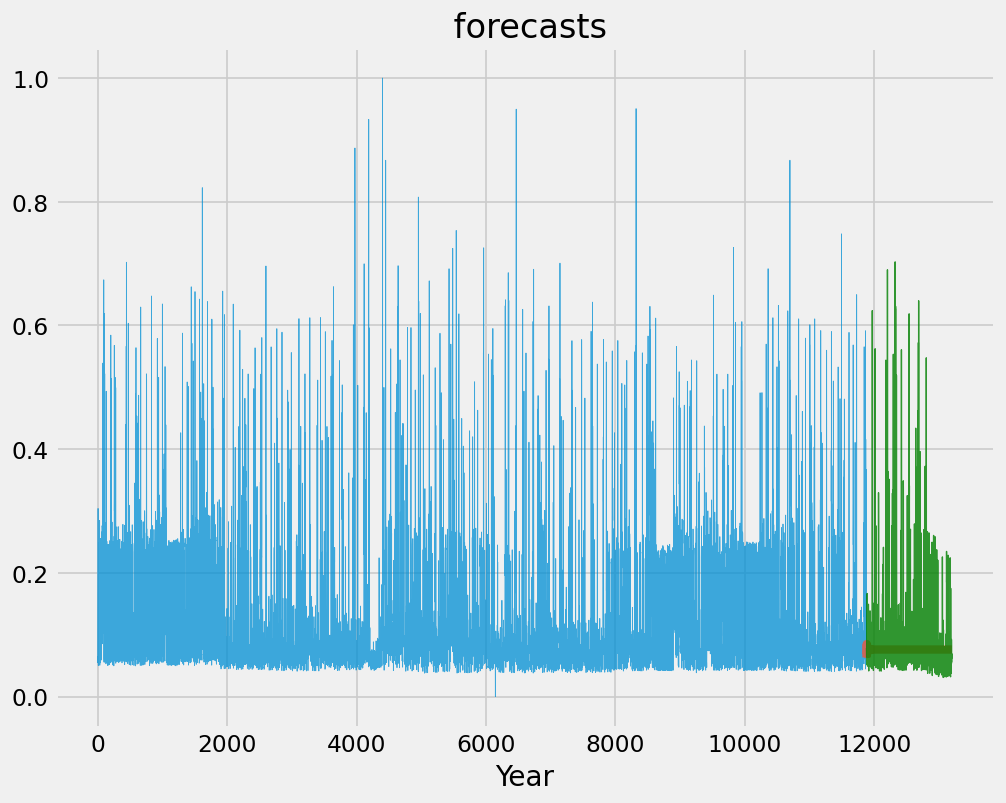

In [130]:
# Plot the points and the forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis 

plt.plot(x_years[x_axis[:train.shape[0]]], train['total'], alpha=0.75, lw=0.5)
plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75, lw=5)  # Forecasts
plt.plot(x_years[x_axis[train.shape[0]:]], test['total'],
            alpha=0.8, c="g", lw=0.8)  # Test data
# plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
#                  conf_int[:, 0], conf_int[:, 1],
#                  alpha=0.1, color='b')
plt.title(" forecasts")
plt.xlabel("Year")

### Forecasting using Prophet


In [131]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [132]:
#Split date
date= "2016-12-01"
X_train = norm_a.loc[norm_a.index<= date].copy()
X_test = norm_a.loc[norm_a.index> date].copy()

<AxesSubplot:xlabel='Date & Time'>

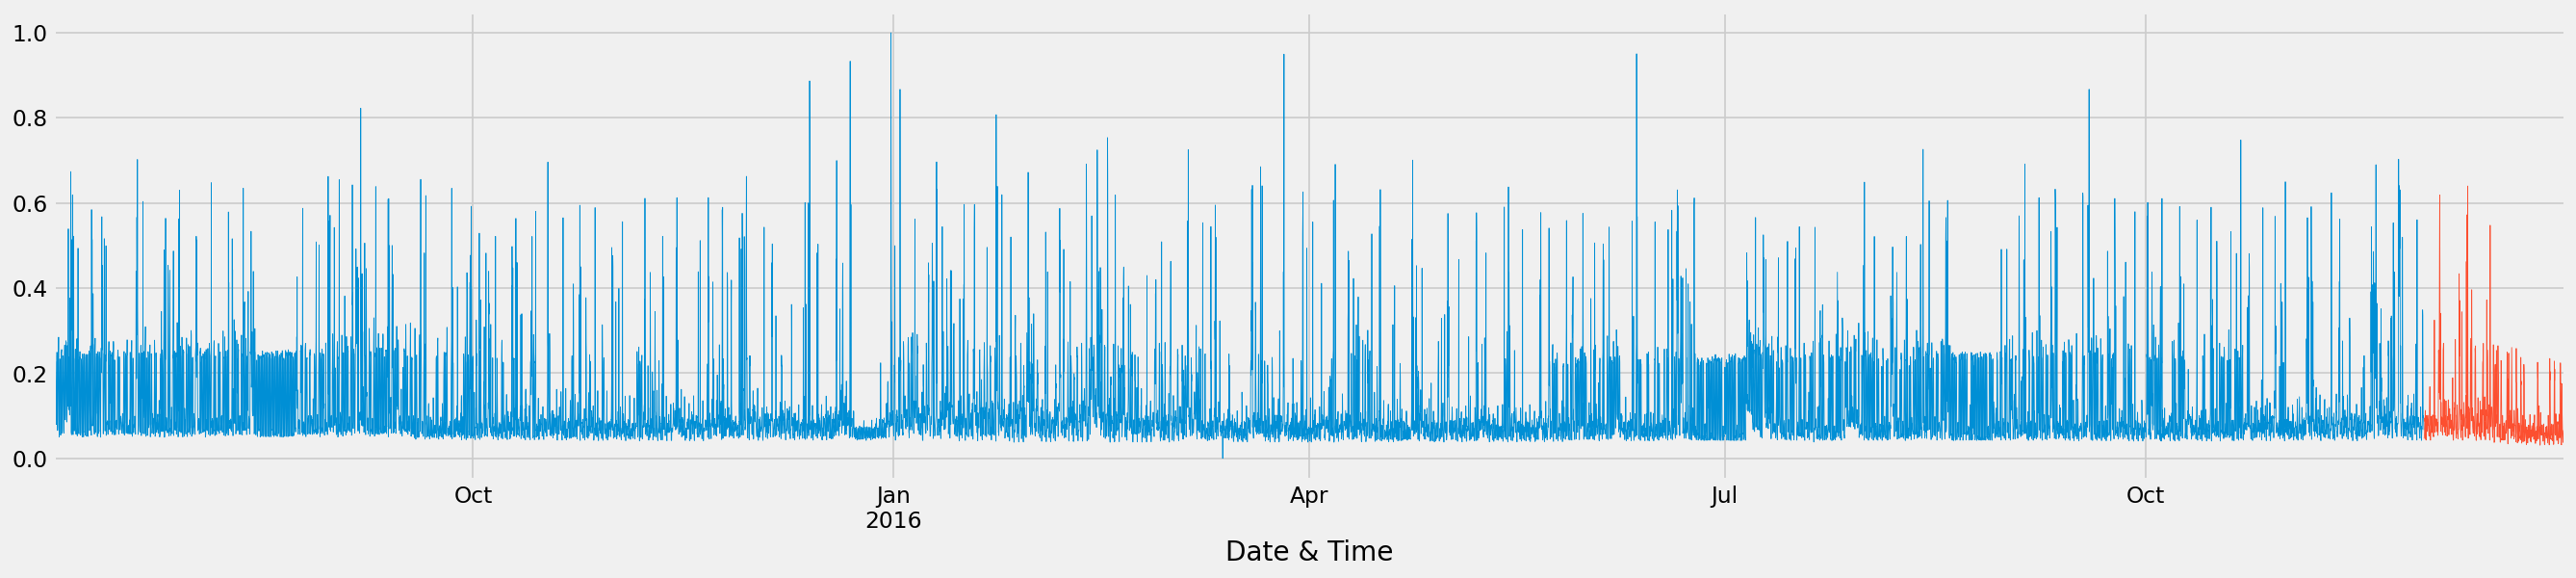

In [133]:
X_train['total'].plot(lw=0.5, figsize=(25,5))
X_test['total'].plot(lw=0.5)

In [106]:
# # Plot train and test so you can see where we have split
# X_train \
#     .rename(columns={'total': 'TRAIN SET'}) \
#     .merge(X_test.rename(columns={'total': 'TEST SET'}),
#           how='outer') \
#     .plot(figsize=(15,5), title='Train/test split', style='.',alpha= 0.5)
# plt.show()

In [134]:
X_train['ds']= X_train.index
X_test['ds'] = X_test.index

X_train = X_train[['ds','total']]
X_test = X_test[['ds','total']]

In [135]:
# Format data for prophet model using ds and y
X_train.reset_index() \
    .rename(columns={
                     'total':'y'}).head()

,Date & Time,ds,y
0,2015-07-01 01:00:00,2015-07-01 01:00:00,0.065098
1,2015-07-01 02:00:00,2015-07-01 02:00:00,0.059671
2,2015-07-01 03:00:00,2015-07-01 03:00:00,0.054732
3,2015-07-01 04:00:00,2015-07-01 04:00:00,0.116063
4,2015-07-01 05:00:00,2015-07-01 05:00:00,0.235996


In [136]:
X_train =X_train.reset_index()
X_train= X_train[['ds','total']]
X_train =X_train.rename(columns={"total":"y"})


In [137]:
model= Prophet(interval_width=0.95,yearly_seasonality=True,weekly_seasonality=True )
model.fit(X_train)

Initial log joint probability = -91.4016
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         23237   0.000142269       84.1816      0.3252      0.9263      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       23237.2   4.88449e-07       49.1952     0.02567        0.45      230   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [138]:
cutoffs = pd.to_datetime(['2016-01-01', '2016-07-01', '2016-12-31'])

In [208]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here



# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(X_train)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs= cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -91.4016
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       22919.9   5.79397e-07       3466.73      0.3084           1      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       22919.9   6.03399e-06       4251.99   1.616e-09       0.001      220  LS failed, Hessian reset 
     151       22919.9   6.07828e-09       3951.84      0.2923      0.2923      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


ValueError: Maximum cutoff value is greater than end date minus horizon, no value for cross-validation remaining

In [139]:
X_test = X_test.reset_index().rename(columns={'total':'y'})

X_test=X_test[['ds','y']]

In [140]:
prediction= model.predict(X_test)

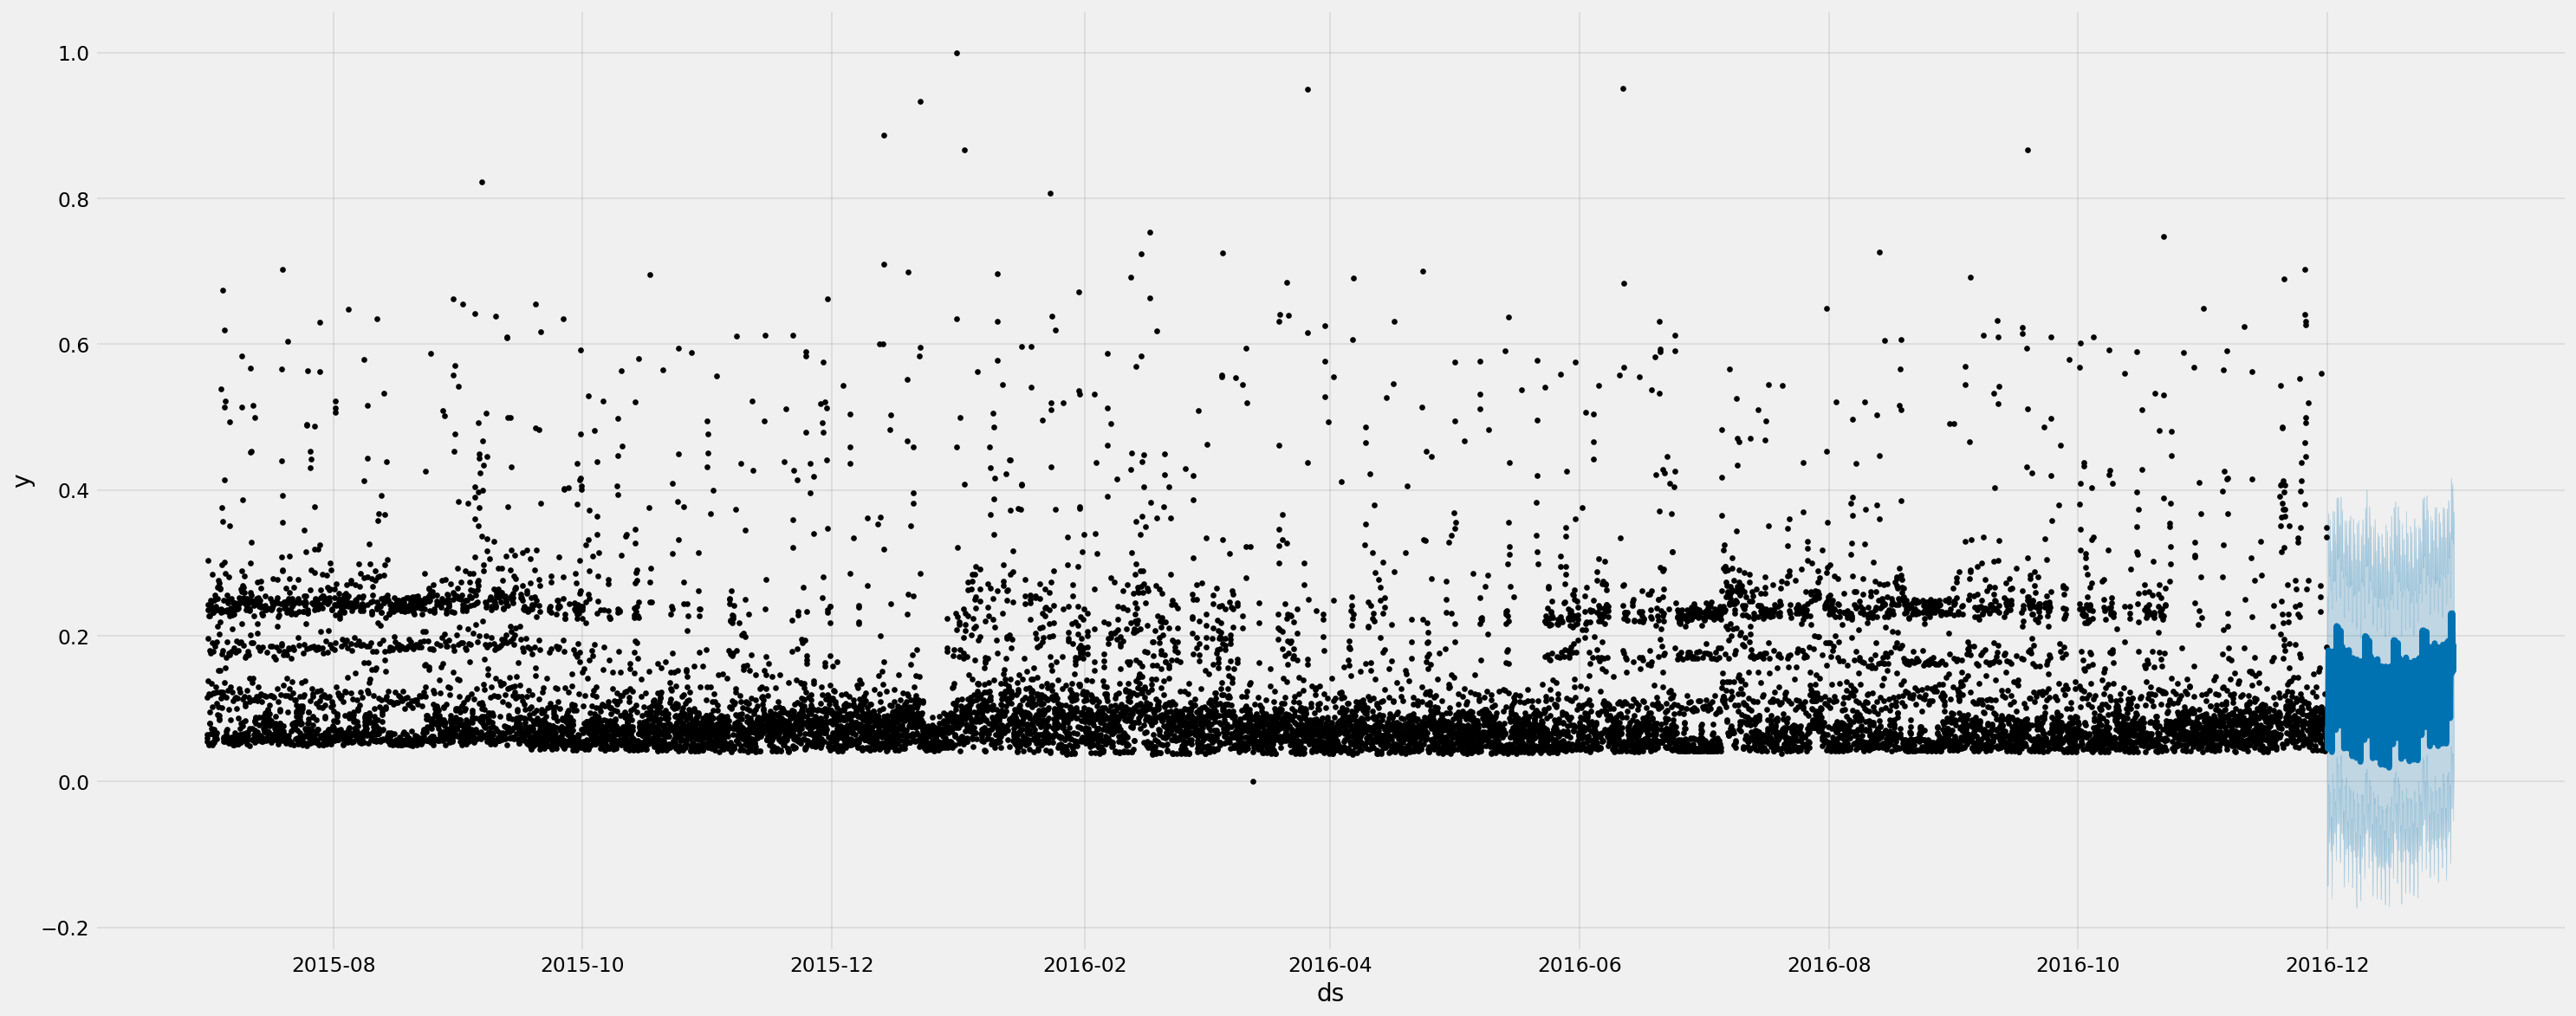

In [141]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(25)
fig = model.plot(prediction,
                 ax=ax)
plt.show()

In [ ]:
##Cross validation with Prophet

df_cv = cross_validation(model, initial='180 days' ,horizon = '30 days')


In [ ]:
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(model.history['ds'].values, model.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
#ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')
ax.text(x=pd.to_datetime('2015-07-01'),y=12, s='Initial', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2015-10-01'),y=12, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
# ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
#           alpha=0.5, ls='--')
ax.text(x=pd.to_datetime('2015-11-01'),y=6, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8);

In [217]:
# Python
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,3 days 00:00:00,0.011549,0.107464,0.068254,0.457738,0.509133,0.944444
1,3 days 01:00:00,0.011560,0.107520,0.068349,0.458715,0.510545,0.944444
2,3 days 02:00:00,0.011570,0.107565,0.068438,0.461138,0.511945,0.944444
3,3 days 03:00:00,0.011586,0.107637,0.068591,0.463307,0.514729,0.944444
4,3 days 04:00:00,0.011609,0.107743,0.068632,0.462129,0.514675,0.944444


### Using XGBoost for Time Series data

In [12]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

import os
import re
from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
from matplotlib.patches import Patch

plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
import warnings
warnings.filterwarnings('ignore')

In [13]:
split_date = "2016-09-18"
home_train = home_a.loc[home_a.index <=split_date].copy()
home_test = home_a.loc[home_a.index >split_date].copy()

In [41]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    cols= df.columns
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['night'] = np.where((df['hour']>=18)| (df['hour']<6),1,0)
    df['lag_hour'] = df['total'].shift(periods=1)
    df['lag_day'] = df['total'].shift(periods=24)
    df['lag_week'] = df['total'].shift(periods=168)
    
    X = df[cols]
    X= X.drop(label, axis=1)
    if label:
        y = df[label]
        return X, y
    return X, cols


In [42]:
X_train, y_train = create_features(home_train, label="total")
X_test, y_test = create_features(home_test, label="total")

In [48]:
X_train= X_train.drop("date",axis=1)
X_test= X_test.drop("date",axis=1)

In [50]:
X_train

,use [kW],gen [kW]_x,FurnaceHRV [kW],CellarOutlets [kW],WashingMachine [kW],FridgeRange [kW],DisposalDishwasher [kW],KitchenLights [kW],BedroomOutlets [kW],BedroomLights [kW],...,quarter,month,year,dayofyear,dayofmonth,night,lag_hour,lag_day,lag_week,weekday
Date & Time,,,,,,,,,,,,,,,,,,,,,
2015-07-01 01:00:00,0.0,0.0,0.009840,0.094779,0.000023,0.000988,0.000084,0.000058,0.016090,0.004670,...,3,7,2015,182,1,1,NaN,NaN,NaN,2
2015-07-01 02:00:00,0.0,0.0,0.009669,0.080487,0.000021,0.000972,0.000086,0.000058,0.015886,0.004650,...,3,7,2015,182,1,1,0.208710,NaN,NaN,2
2015-07-01 03:00:00,0.0,0.0,0.009715,0.064069,0.000017,0.000971,0.000084,0.000058,0.015926,0.004659,...,3,7,2015,182,1,1,0.191311,NaN,NaN,2
2015-07-01 04:00:00,0.0,0.0,0.208286,0.061939,0.000532,0.000922,0.000192,0.000096,0.015855,0.004672,...,3,7,2015,182,1,1,0.175475,NaN,NaN,2
2015-07-01 05:00:00,0.0,0.0,0.577512,0.077067,0.001520,0.000826,0.000389,0.000164,0.015639,0.004661,...,3,7,2015,182,1,1,0.372108,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-17 20:00:00,0.0,0.0,0.036421,0.064332,0.001397,0.000571,0.000265,0.000084,0.018056,0.015611,...,3,9,2016,261,17,1,0.196232,0.246989,0.294948,5
2016-09-17 21:00:00,0.0,0.0,0.066703,0.088483,0.000937,0.001189,0.000205,0.000063,0.010633,0.004527,...,3,9,2016,261,17,1,0.213909,0.220503,0.793349,5
2016-09-17 22:00:00,0.0,0.0,0.093624,0.087141,0.000620,0.000730,0.000196,0.000059,0.010078,0.004577,...,3,9,2016,261,17,1,0.232902,0.265371,0.551558,5


In [86]:
create_features(norm_a)

In [87]:
norm_a= norm_a.drop(['use [kW]','gen [kW]_x','gen [kW]_y','date'], axis=1)

In [89]:
X = norm_a.drop(['total'], axis=1)
y= norm_a['total']

In [43]:
reg = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}


In [44]:
xgb_grid = GridSearchCV(reg,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [92]:
X=X.reset_index()
X.drop(["Date & Time"], axis=1,inplace=True)

In [93]:
X=X.values
y= y.values

In [94]:
tscv = TimeSeriesSplit(n_splits=3,
    max_train_size=4320)


In [ ]:

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    xgb_grid.fit(
        X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)
    


In [100]:
xgb_grid.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=Non

In [49]:
xgb_grid.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/xgboost/sklearn.py", line 761, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/xgboost/sklearn.py", line 286, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  Fil

ValueError: feature_names must be string, and may not contain [, ] or <

In [ ]:
len(home_train)

In [ ]:
home_test['prediction'] = xgb_grid.predict(X_test)

In [ ]:
home_all= pd.concat([home_train, home_test], sort=False)

In [135]:
_=home_all.loc[home_all.index>'2014-11-01'][['total','prediction']].plot(figsize=(15,10), lw=0.5)

NameError: name 'home_all' is not defined

### Using LSTMs 

In [60]:
# Convert to numpy arrays after preprocessing

energy= home_a['total'].values
energy = energy.reshape(len(energy),1)
energy= energy.astype('float32')
print(energy.shape)
energy

(13199, 1)


array([[0.20871028],
       [0.19131055],
       [0.175475  ],
       ...,
       [0.22226584],
       [0.20390445],
       [0.19684666]], dtype=float32)

In [61]:
# Data partitining 
train_size  = int(len(energy) * 0.70)
test_size   = len(energy) - train_size
train, test = energy[:train_size], energy[train_size:]

In [62]:
# Scaling the data to the interval [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [63]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [64]:
plot_pacf(energy,lags=24)

NameError: name 'plot_pacf' is not defined

In [96]:
timesteps = 8 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
X_train.shape

(9231, 8, 1)

In [97]:
X_train

array([[[0.06509796],
        [0.05967088],
        [0.05473167],
        ...,
        [0.24303815],
        [0.30411825],
        [0.19633424]],

       [[0.05967088],
        [0.05473167],
        [0.11606276],
        ...,
        [0.30411825],
        [0.19633424],
        [0.138429  ]],

       [[0.05473167],
        [0.11606276],
        [0.23599592],
        ...,
        [0.19633424],
        [0.138429  ],
        [0.05194705]],

       ...,

       [[0.17291194],
        [0.24013422],
        [0.2316385 ],
        ...,
        [0.06740138],
        [0.06735867],
        [0.06039476]],

       [[0.24013422],
        [0.2316385 ],
        [0.2270541 ],
        ...,
        [0.06735867],
        [0.06039476],
        [0.17572393]],

       [[0.2316385 ],
        [0.2270541 ],
        [0.13013414],
        ...,
        [0.06039476],
        [0.17572393],
        [0.22778128]]], dtype=float32)

In [98]:
from keras.preprocessing.sequence import TimeseriesGenerator

# Create input data from time series
demo = TimeseriesGenerator(train, train, length = timesteps, sampling_rate=1, batch_size=1)
print('Length of the output is {}.'.format(len(demo)))

# As result, we get a set of tuples (x, y) which we can enumerate and index
demo_x0 = demo[0][0]
demo_y0 = demo[0][1]
print(demo_x0)
print(X_train[0])   # Compare that to the above

# Likewise
print(demo_y0)
print(y_train[0])

# Here is an example to transform the output of TimeseriesGenerator to match the structure of X_train
demo_x = np.asarray([x[0] for x in demo])
print('Shape of demo_x {}'.format(demo_x.shape))
demo_x = np.reshape(demo_x, (len(demo), timesteps, 1))

# Confirm the two data structures are equivalent
print('Difference of the two data containers should be zero and evaluates to {}'.format(
    np.sum(demo_x - X_train)))

Length of the output is 9231.
[[[0.06509796]
  [0.05967088]
  [0.05473167]
  [0.11606276]
  [0.23599592]
  [0.24303815]
  [0.30411825]
  [0.19633424]]]
[[0.06509796]
 [0.05967088]
 [0.05473167]
 [0.11606276]
 [0.23599592]
 [0.24303815]
 [0.30411825]
 [0.19633424]]
[[0.138429]]
[0.138429]
Shape of demo_x (9231, 1, 8, 1)
Difference of the two data containers should be zero and evaluates to 0.0


In [99]:
# Reshape input to be [obs, time steps, features]

X_train  = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test   = np.reshape(X_test,  (X_test.shape[0],  X_test.shape[1],  1))
print(X_train.shape,y_train.shape, X_test.shape,y_test.shape)

(9231, 8, 1) (9231, 1) (3952, 8, 1) (3952, 1)


#### Evaluation and Benchmark

In [100]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [101]:
rmse_train = {}
rmse_test = {}

p=1 RMSE:0.09432
p=2 RMSE:0.11934
p=3 RMSE:0.13290
p=4 RMSE:0.14157
p=5 RMSE:0.13985
p=6 RMSE:0.13365
p=7 RMSE:0.12922
p=8 RMSE:0.12611
p=9 RMSE:0.13099
p=10 RMSE:0.13779
p=11 RMSE:0.14521
p=12 RMSE:0.14949
p=13 RMSE:0.14599
p=14 RMSE:0.14009
p=15 RMSE:0.13472
p=16 RMSE:0.13124
p=17 RMSE:0.13403
p=18 RMSE:0.13994
p=19 RMSE:0.14521
p=20 RMSE:0.14717
p=21 RMSE:0.14404
p=22 RMSE:0.13624
p=23 RMSE:0.12818
p=24 RMSE:0.12438
p=25 RMSE:0.12883
p=26 RMSE:0.13555
p=27 RMSE:0.14255
p=28 RMSE:0.14728
p=29 RMSE:0.14399
p=30 RMSE:0.13803
p=31 RMSE:0.13338
p=32 RMSE:0.13067
p=33 RMSE:0.13498
p=34 RMSE:0.14099
p=35 RMSE:0.14679
p=36 RMSE:0.15026
p=37 RMSE:0.14731
p=38 RMSE:0.14100
p=39 RMSE:0.13520
p=40 RMSE:0.13100
p=41 RMSE:0.13540
p=42 RMSE:0.14097
p=43 RMSE:0.14671
p=44 RMSE:0.14870
p=45 RMSE:0.14451
p=46 RMSE:0.13940
p=47 RMSE:0.13374
p=48 RMSE:0.12980
p=49 RMSE:0.13398
p=50 RMSE:0.14089
p=51 RMSE:0.14736
p=52 RMSE:0.15009
p=53 RMSE:0.14862
p=54 RMSE:0.14308
p=55 RMSE:0.13805
p=56 RMSE:0.13459
p

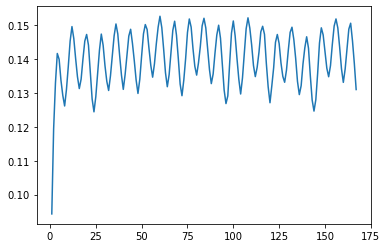

In [102]:
# Persistence code from machinelearningmastery.com/simple-time-series-forecasting-models/

persistence_values = range(1, 168) # how many days back (within a month) should we go as a forecast for tomorrow
scores = list()
for p in persistence_values:
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
    # make prediction
        yhat = history[-p]
        predictions.append(yhat)
    # observation
        history.append(test[i])
    # report performance
    error = rmse(test, predictions)
    scores.append(error)
    print('p=%d RMSE:%.5f' % (p, error))
# plot scores over persistence values
plt.plot(persistence_values, scores)
plt.show()

In [103]:
# Lag for the naive benchmark (i.e., persistence forecast)
k_naive = 1
# Since the persistenc forecasts looks at a past value of the time series, it is convenient to use the Pandas function shift()
# for calculating the benchmark. So we first collect the actual time series in a data frame,
pred_naive = pd.DataFrame(np.vstack([y_train, y_test]))
# and then use shift with our selected lag k_naive, while filling up NaN values at the beginning of the time series with the mean.
# Since we will never use the start of the time series (i.e., first samples in the training set) for testing, the mean replacement does 
# not affect subsequent results. 
pred_naive = pred_naive.shift(periods=k_naive, axis=0, fill_value=np.mean(y_train)).values

In [104]:
# We use one dictionary for the training and one for the test data
pred_test = {}
pred_train = {}

# We store the actual price differences as opposed to their scaled version
pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

# Also add the lagged persistence forecast
pred_train["naive"] = scaler.inverse_transform(pred_naive[:len(y_train), :]).flatten()  # This is a good example of why the [a, b-1] 
pred_test["naive"]  = scaler.inverse_transform(pred_naive[len(y_train):, :]).flatten()  # indexing is convenient

In [105]:
len(pred_train['true'])

9231

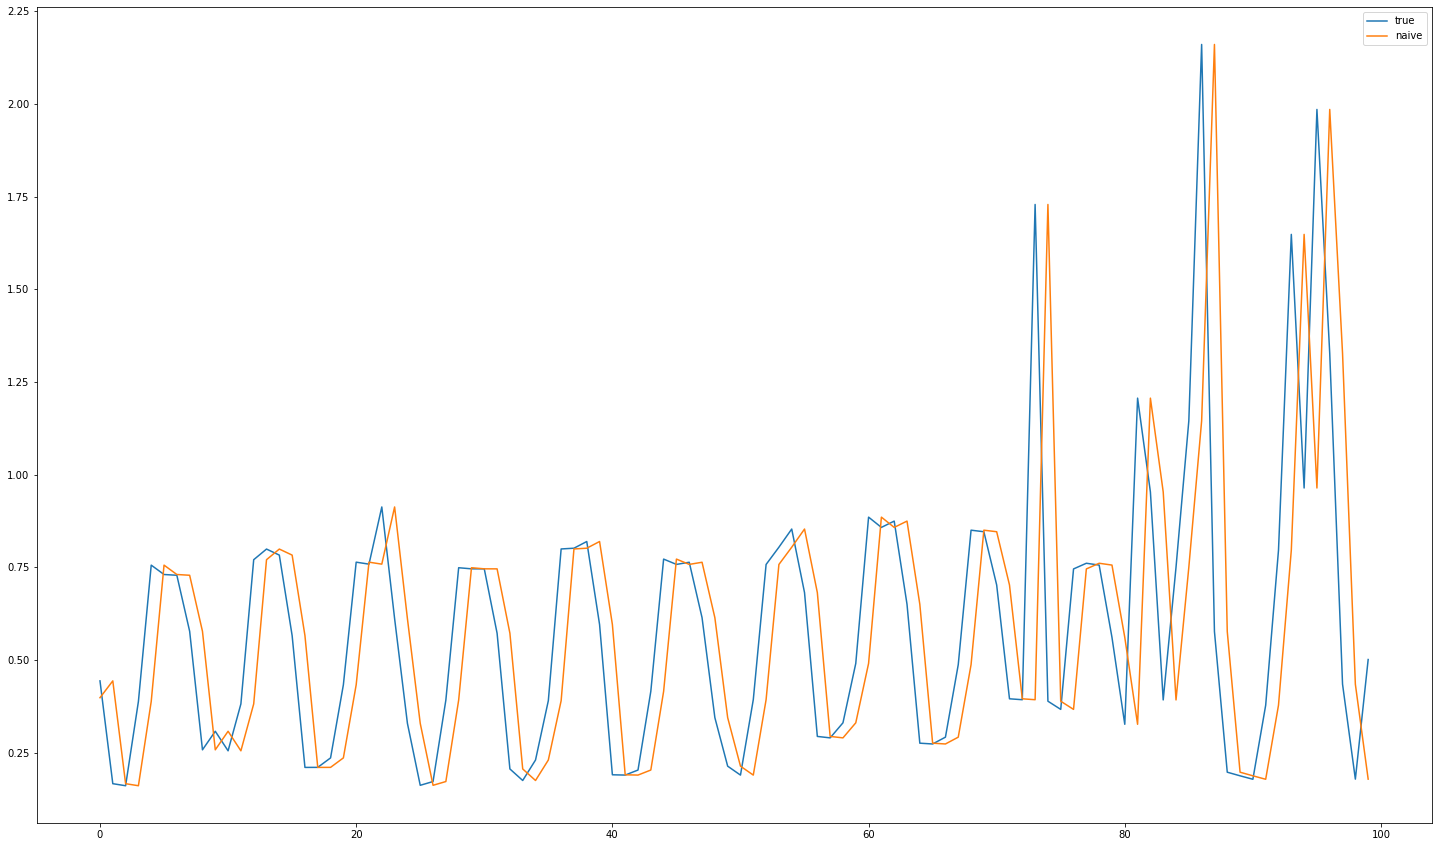

In [106]:
pd.DataFrame(pred_train).iloc[0:100,:].plot(figsize=(25,15))
plt.show()

In [107]:
rmse_train["naive"] = rmse(pred_train["true"], pred_train["naive"])
rmse_test["naive"]  = rmse(pred_test["true"],  pred_test["naive"])

rmse_test

{'naive': 0.30254447}

In [108]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [109]:
# Define the model
batch_size = 32 # An arbitrary choice
stateless = Sequential()
stateless.add(LSTM(8))  # size of the LSTM hidden state, we select 7 units; also arbitrary 
stateless.add(Dense(1))
stateless.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

# Training
stateless.fit(X_train, y_train, batch_size=batch_size, epochs=30, validation_split=0.3, verbose=1)
stateless.summary()

Epoch 1/30
202/202 [==============================] - 4s 10ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 2/30
202/202 [==============================] - 1s 6ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 3/30
202/202 [==============================] - 1s 5ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 4/30
202/202 [==============================] - 1s 5ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 5/30
202/202 [==============================] - 1s 5ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/30
202/202 [==============================] - 1s 5ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/30
202/202 [==============================] - 1s 6ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8/30
202/202 [==============================] - 1s 5ms/step - loss: 0

In [110]:
# Input data for prediction as 3d array [samples / time steps / features]
stateless.predict(X_test[0].reshape(1, timesteps, 1))

array([[0.22286789]], dtype=float32)

In [111]:
#Compare to the test data
y_test[0]

array([0.27525726], dtype=float32)

In [112]:
# Define the model
demo = Sequential()
demo.add(LSTM(7, return_sequences=True))
demo.add(Dense(1))

demo.predict(X_test[0].reshape(-1, timesteps, 1))

array([[[0.00183257],
        [0.00540735],
        [0.00818295],
        [0.00988876],
        [0.01092375],
        [0.01249409],
        [0.01593876],
        [0.02076788]]], dtype=float32)

In [113]:
# Silly (!) copying of y values to showcase how target values would need to be organized
tmp_y  = np.repeat(y_train, timesteps, axis=1).reshape(-1, timesteps, 1)
demo.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])
# Training
demo.fit(X_train, tmp_y, batch_size=batch_size, epochs=10, validation_split=0.3, verbose=0)

In [114]:
# Remember that we need to reverse the scaling. This is equivalent to the above code for the persistence benchmark
pred_train["stateless"] = scaler.inverse_transform(
                              stateless.predict(X_train,verbose=0)
).flatten()

pred_test["stateless"] = scaler.inverse_transform(
stateless.predict(X_test,verbose=0)
).flatten()

Train Score of stateless LSTM: 0.269938 RMSE
Test Score of stateless LSTM:  0.256765 RMSE


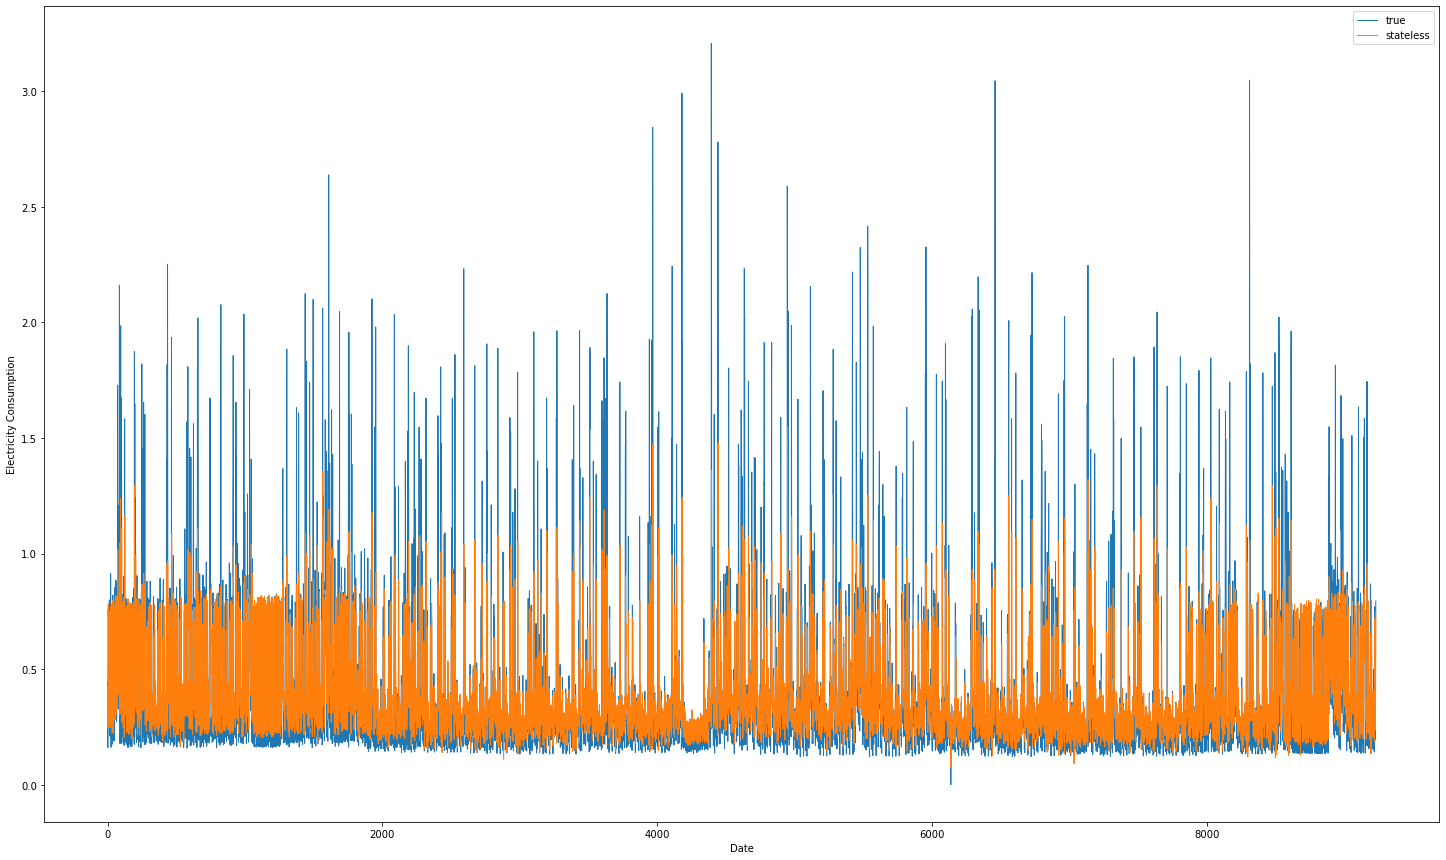

In [115]:
# Compute RMSE
rmse_train["stateless"] = rmse(pred_train["true"], pred_train["stateless"])
rmse_test["stateless"]  = rmse(pred_test["true"],  pred_test["stateless"])

print('Train Score of stateless LSTM: %.6f RMSE' % (rmse_train["stateless"]))
print('Test Score of stateless LSTM:  %.6f RMSE' % (rmse_test["stateless"]))

# Plot actuals and forecasts
pd.DataFrame(pred_train)[["true","stateless"]].plot(figsize=(25,15), lw=1)
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.show()

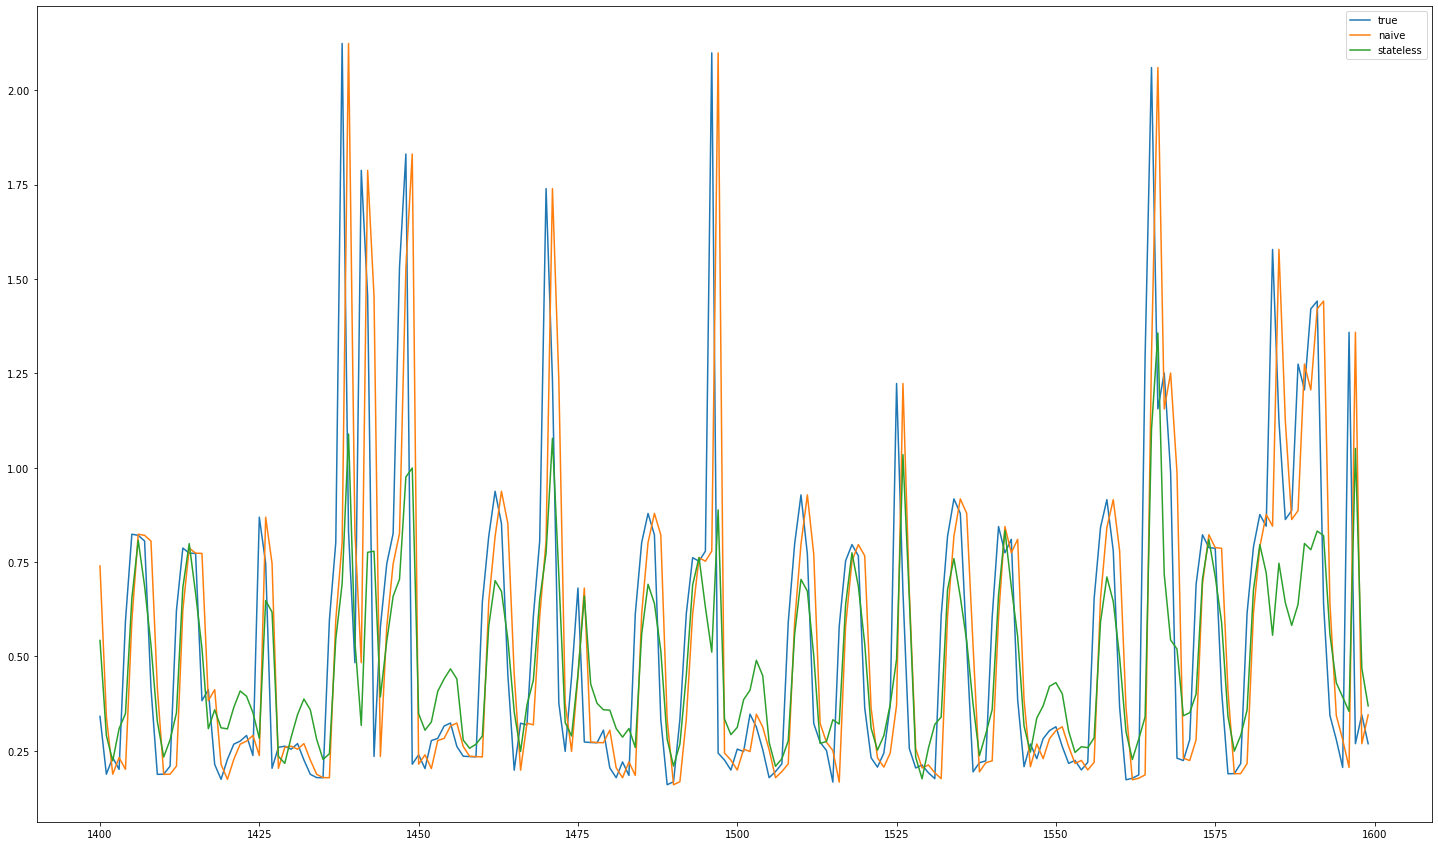

In [116]:
pd.DataFrame(pred_train).iloc[1400:1600,:].plot(figsize=(25,15));

In [117]:
pred_train

{'true': array([0.44381666, 0.16654722, 0.16102472, ..., 0.56338775, 0.7302886 ,
        0.79515666], dtype=float32),
 'naive': array([0.39840436, 0.44381666, 0.16654722, ..., 0.19363138, 0.56338775,
        0.7302886 ], dtype=float32),
 'stateless': array([0.4260047 , 0.34635165, 0.24806191, ..., 0.33256805, 0.62760365,
        0.75150055], dtype=float32)}

### Multiple layers

In [118]:
stateless_multilayer = Sequential()
stateless_multilayer.add(LSTM(7, return_sequences=True))
stateless_multilayer.add(Dropout(0.2))  # you can also add dropout layers if you like
stateless_multilayer.add(LSTM(7, return_sequences=False))
stateless_multilayer.add(Dropout(0.2))
stateless_multilayer.add(Dense(1))
stateless_multilayer.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [119]:
y_train.shape

(9231, 1)

In [120]:
stateless_multilayer.fit(X_train, y_train, batch_size=batch_size,epochs=30, validation_split=0.3 )

Epoch 1/30
202/202 [==============================] - 6s 13ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 2/30
202/202 [==============================] - 2s 9ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 3/30
202/202 [==============================] - 2s 8ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 4/30
202/202 [==============================] - 2s 9ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 5/30
202/202 [==============================] - 2s 8ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 6/30
202/202 [==============================] - 2s 8ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 7/30
202/202 [==============================] - 2s 8ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 8/30
202/202 [==============================] - 2s 9ms/step - loss: 0

Train Score: 0.270777 RMSE
Test Score: 0.256736 RMSE


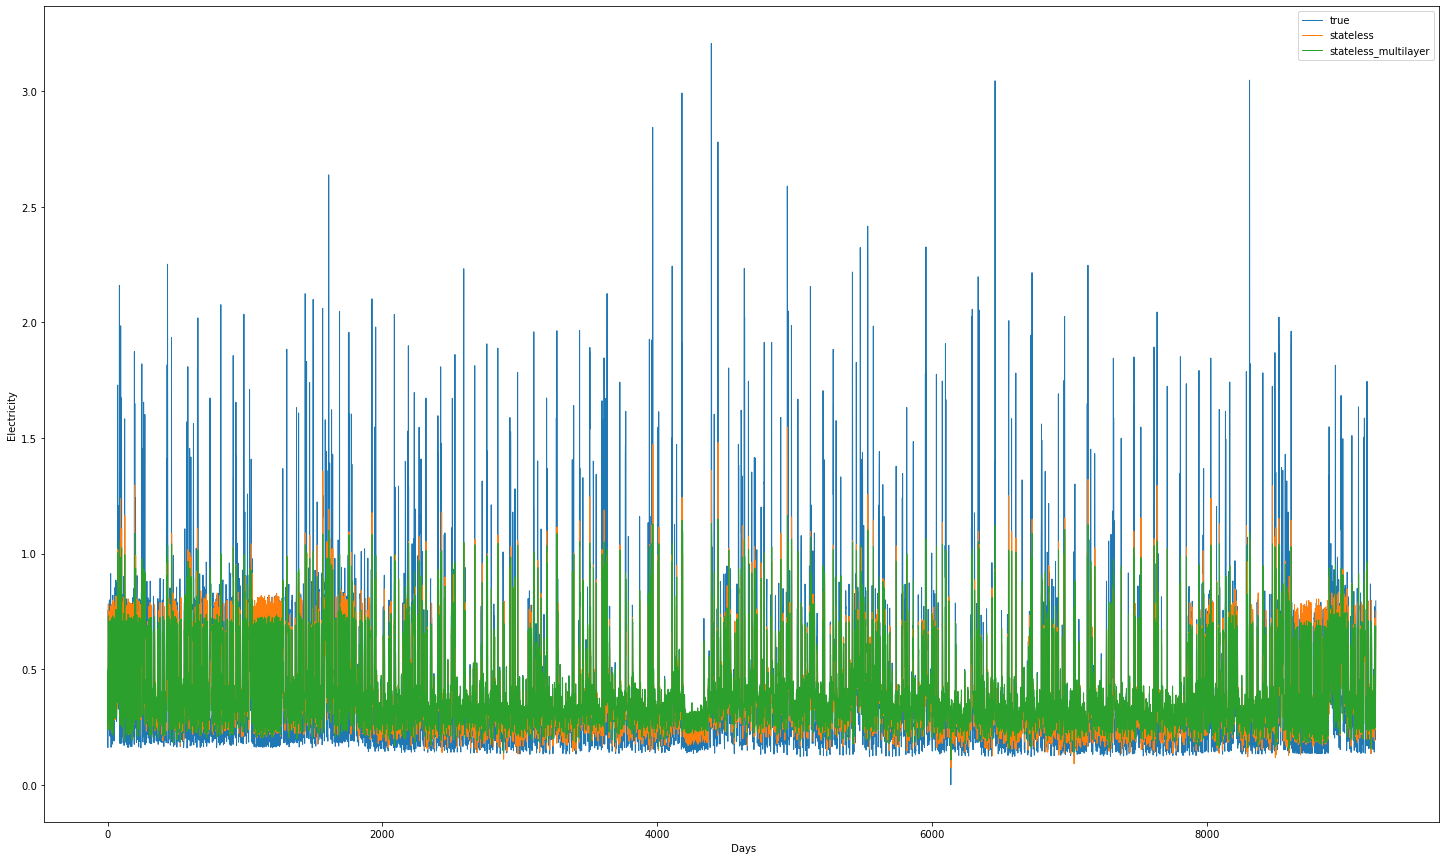

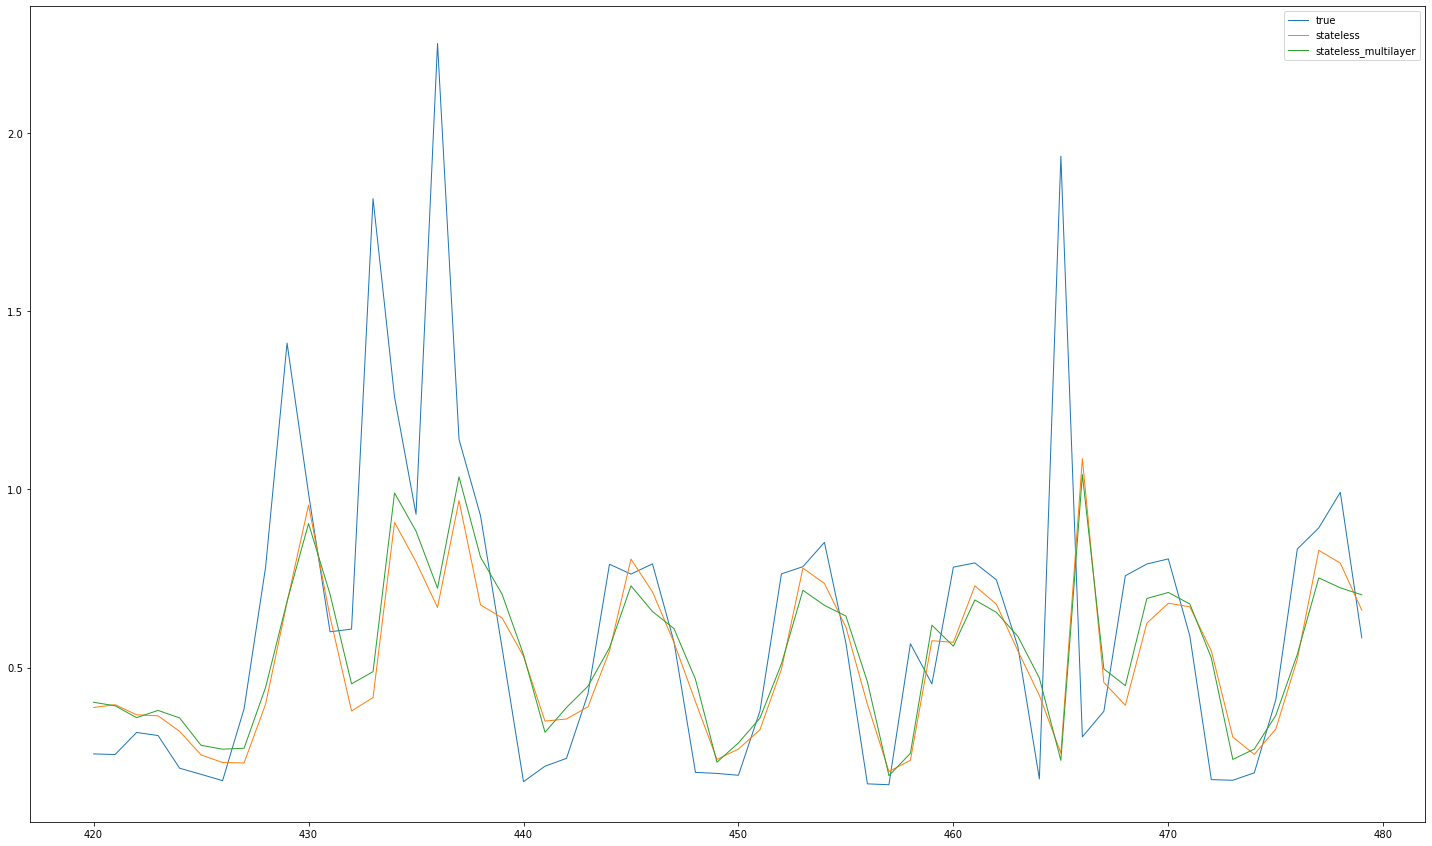

In [121]:
# Error assessment of the stacked LSTM
pred_train["stateless_multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_train,verbose=0)
).flatten()

pred_test["stateless_multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_test,verbose=0)
).flatten()

rmse_train["stateless_multilayer"] = rmse(pred_train["true"], pred_train["stateless_multilayer"])
rmse_test["stateless_multilayer"] = rmse(pred_test["true"], pred_test["stateless_multilayer"])

print('Train Score: %.6f RMSE' % (rmse_train["stateless_multilayer"]))
print('Test Score: %.6f RMSE' % (rmse_test["stateless_multilayer"]))

# Plot of forecasts and actuals
pd.DataFrame(pred_train)[["true","stateless","stateless_multilayer"]].plot(figsize=(25,15), lw=1)
plt.xlabel(' Days')
plt.ylabel('Electricity')
plt.show()

# and again for a specific time interval 
pd.DataFrame(pred_train)[["true","stateless","stateless_multilayer"]].iloc[420:480,:].plot(figsize=(25,15), lw=1)
plt.show()

## Convolutional LSTMS

Code taken from https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [41]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 


In [ ]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

In [125]:
n_steps = 8
#X, y = split_sequence(train, n_steps)


In [59]:
print(X.shape)
print(X_train.shape)

(9215, 24, 1)
(9215, 24, 1)


In [150]:
#Define model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


In [151]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [152]:
conv = Sequential()
conv.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
conv.add(MaxPooling1D(pool_size=2))
conv.add(Flatten())
conv.add(Dense(50, activation='relu'))
conv.add(Dense(1))
conv.compile(optimizer='adam', loss='mse')

In [153]:
conv.fit(X_train,y_train, epochs=30, verbose=1)

Epoch 1/30
289/289 [==============================] - 1s 2ms/step - loss: 0.0098
Epoch 2/30
289/289 [==============================] - 1s 2ms/step - loss: 0.0089
Epoch 3/30
289/289 [==============================] - 1s 2ms/step - loss: 0.0087
Epoch 4/30
289/289 [==============================] - 1s 2ms/step - loss: 0.0088
Epoch 5/30
289/289 [==============================] - 1s 2ms/step - loss: 0.0086
Epoch 6/30
289/289 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 7/30
289/289 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 8/30
289/289 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 9/30
289/289 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 10/30
289/289 [==============================] - 1s 2ms/step - loss: 0.0084
Epoch 11/30
289/289 [==============================] - 1s 2ms/step - loss: 0.0084
Epoch 12/30
289/289 [==============================] - 1s 2ms/step - loss: 0.0084
Epoch 13/30
289/289 [====

In [154]:

test = test.reshape((1, n_steps, n_features))
yhat = conv.predict(test[0], verbose=0)
print(yhat)

ValueError: cannot reshape array of size 3960 into shape (1,8,1)

In [155]:
for layer in conv.layers:
    weights = layer.get_weights()

In [156]:
yhat= conv.predict(X_test)

In [157]:
y_test1 = y_test.reshape()
y_test1= pd.Series(y_test)

#yhat = pd.Series(yhat)

TypeError: reshape() takes exactly 1 argument (0 given)

In [158]:
preds=pd.DataFrame({"y_test": [y_test], "yhat": [yhat]})

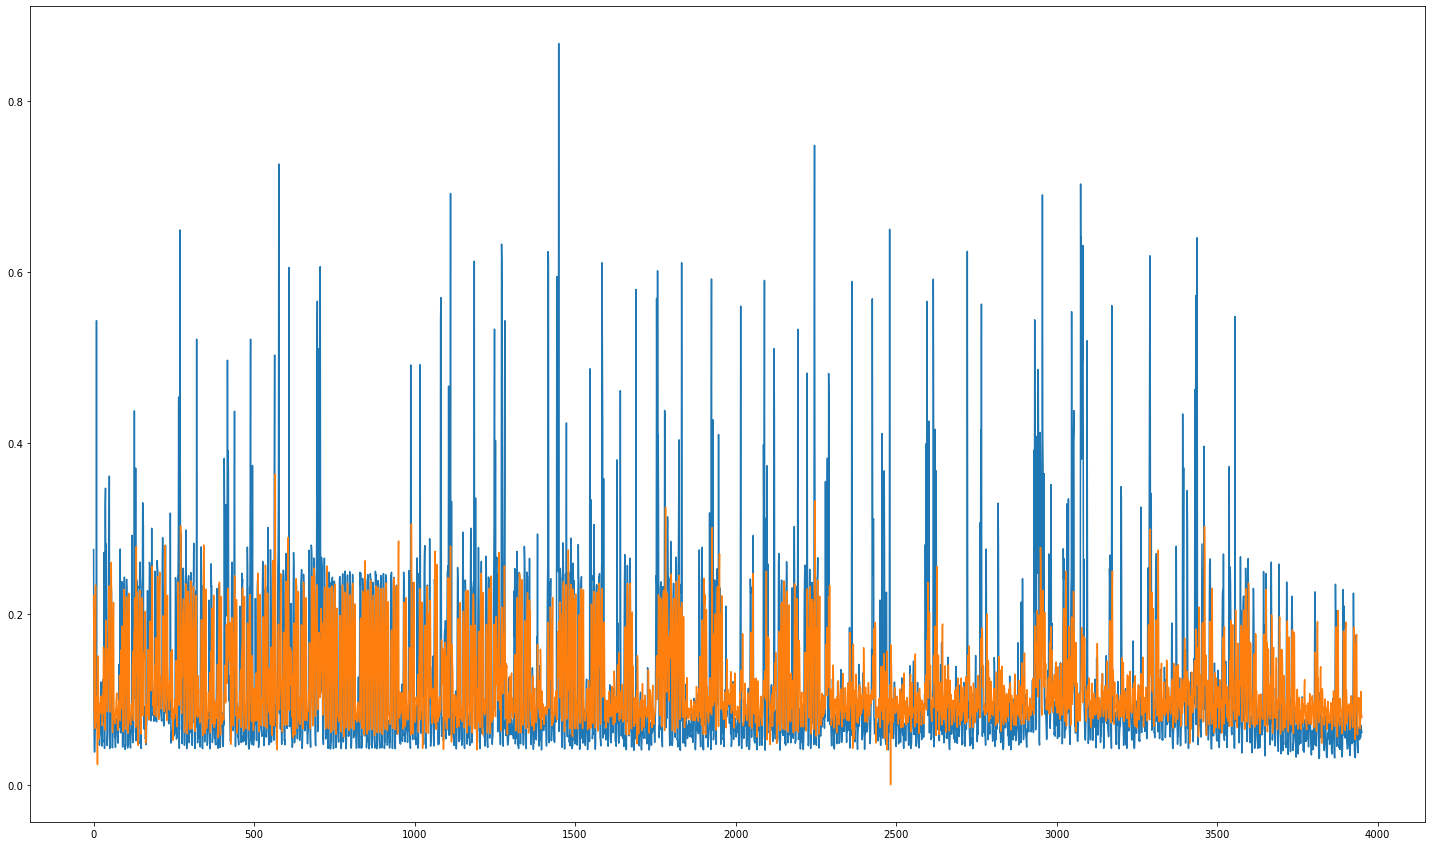

In [164]:
plt.rcParams["figure.figsize"] = (25,15)
plt.plot(y_test)
plt.plot(yhat)
